<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>

In [ ]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [1]:
import h5py
import numpy as np
import scipy.io.wavfile as wavfile

# Ruta al archivo H5
ruta_archivo = "/content/L-L1_GWOSC_4KHZ_R1-1249852241-32.hdf5"  # Reemplaza con la ruta real

# Abre el archivo H5
with h5py.File(ruta_archivo, 'r') as archivo:
    # Accede al dataset de strain (deformación)
    strain = archivo['strain']['Strain'][:]

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

In [19]:
# Convierte a audio WAV (normalizando la señal para evitar clipping)
strain_normalizado = strain / np.max(np.abs(strain))
wavfile.write("strain.wav", 4096, strain_normalizado) # Ajusta la frecuencia de muestreo si es diferente

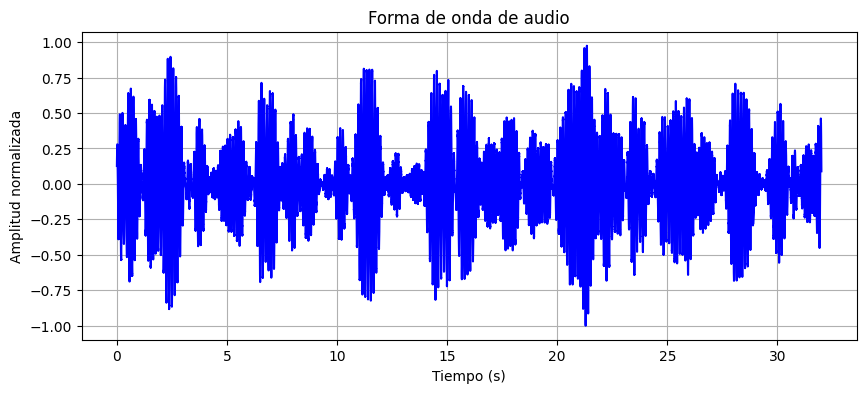

In [3]:
import matplotlib.pyplot as plt

# Leer el archivo de audio WAV
fs, strain_normalizado = wavfile.read("strain.wav")

# Calcular la duración del audio en segundos
duration = len(strain_normalizado) / fs

# Crear un arreglo de tiempo
time = np.linspace(0., duration, len(strain_normalizado))

# Graficar la forma de onda del audio
plt.figure(figsize=(10, 4))
plt.plot(time, strain_normalizado, color='b')
plt.title('Forma de onda de audio')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud normalizada')
plt.grid(True)
plt.show()

## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


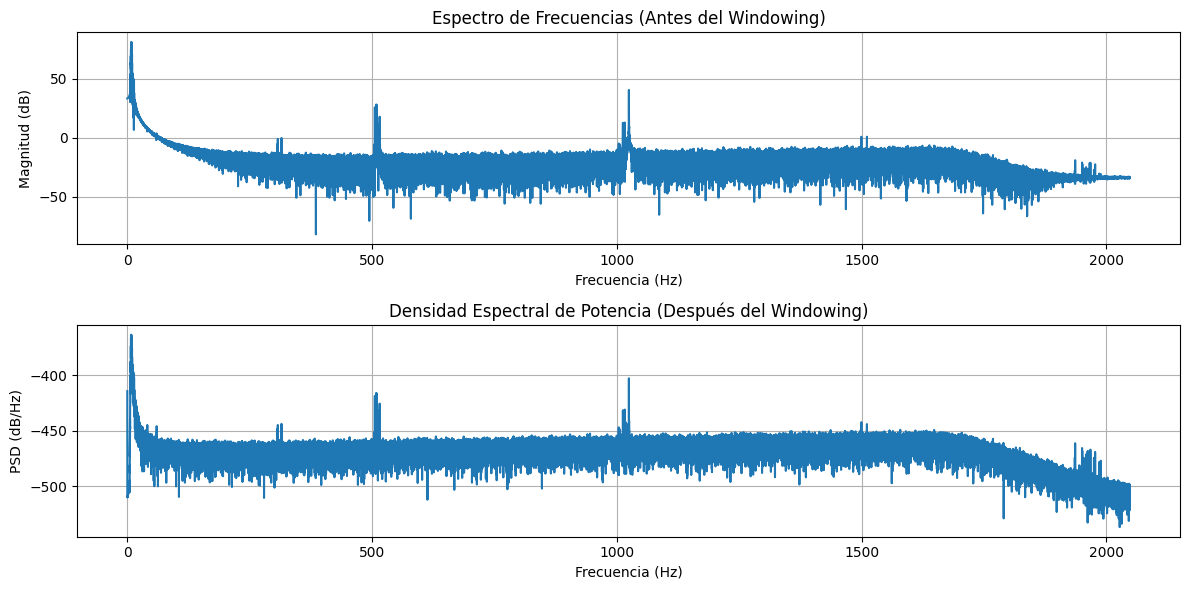

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import welch

# Suponiendo que tienes tus datos de strain y que ya has eliminado el offset de DC

# Calcular la FFT
fft_valores = fft(strain_normalizado)
frecuencias = fftfreq(strain.size, d=1/4096)

# Seleccionar las frecuencias positivas y sus magnitudes
frecuencias_positivas = frecuencias[:len(frecuencias)//2]
magnitudes_positivas = np.abs(fft_valores)[:len(fft_valores)//2]

# Calcular la densidad espectral de potencia (PSD)
f_psd, psd = welch(strain, fs=4096, nperseg=len(strain))

# Convertir las magnitudes a dB
magnitudes_dB = 20 * np.log10(magnitudes_positivas)
psd_dB = 10 * np.log10(psd)

# Graficar el espectro de frecuencias (solo frecuencias positivas) antes y después del windowing
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frecuencias_positivas, magnitudes_dB)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.title('Espectro de Frecuencias (Antes del Windowing)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(f_psd, psd_dB)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.title('Densidad Espectral de Potencia (Después del Windowing)')
plt.grid(True)

plt.tight_layout()
plt.show()


## 4. Procesamiento
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


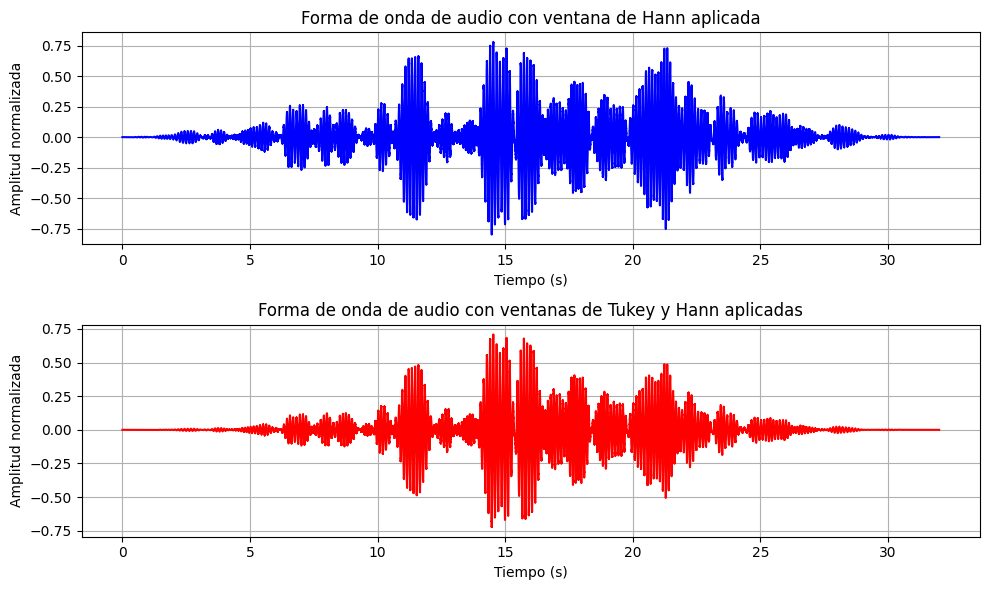

In [5]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# Leer el archivo de audio WAV
fs, strain_normalizado = wavfile.read("strain.wav")

# Calcular la duración del audio en segundos
duration = len(strain_normalizado) / fs

# Crear un arreglo de tiempo
time = np.linspace(0., duration, len(strain_normalizado))

# Crear una ventana de Hann del mismo tamaño que el audio
hann_window = np.hanning(len(strain_normalizado))

# Aplicar la ventana de Hann al audio
strained_hann = strain_normalizado * hann_window

# Crear una ventana de Tukey
alpha = 0.5  # Parámetro de la ventana de Tukey (0: ventana rectangular, 1: ventana de Hann)
tukey_window = np.concatenate([
    np.linspace(0, 1, int(len(strain_normalizado) * alpha)),
    np.ones(len(strain_normalizado) - int(len(strain_normalizado) * alpha) * 2),
    np.linspace(1, 0, int(len(strain_normalizado) * alpha))
])

# Aplicar la ventana de Tukey al audio después de la ventana de Hann
strained_tukey = strained_hann * tukey_window

# Graficar la forma de onda del audio con la ventana de Hann aplicada
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, strained_hann, color='b')
plt.title('Forma de onda de audio con ventana de Hann aplicada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud normalizada')
plt.grid(True)

# Graficar la forma de onda del audio con la ventana de Tukey y Hann aplicadas
plt.subplot(2, 1, 2)
plt.plot(time, strained_tukey, color='r')
plt.title('Forma de onda de audio con ventanas de Tukey y Hann aplicadas')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud normalizada')
plt.grid(True)

plt.tight_layout()
plt.show()

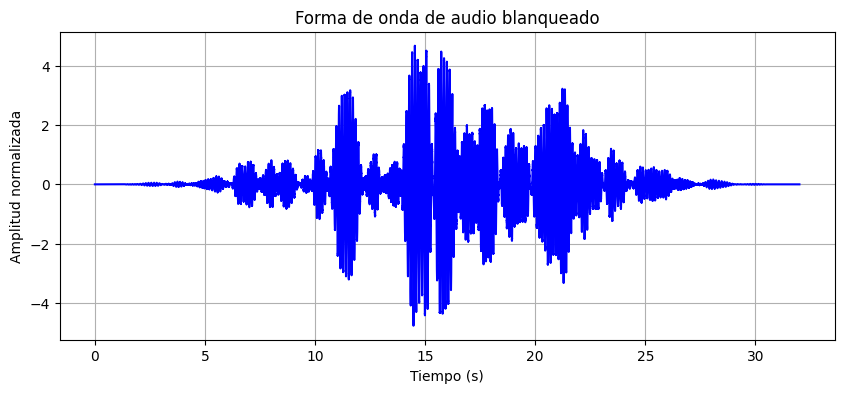

In [6]:
from scipy.signal import lfilter

# Calcular la media de la señal
mean_strained_tukey = np.mean(strained_tukey)

# Calcular la desviación estándar de la señal
std_strained_tukey = np.std(strained_tukey)

# Blanquear la señal
whitened_strained_tukey = (strained_tukey - mean_strained_tukey) / std_strained_tukey

# Graficar la forma de onda del audio blanqueado
plt.figure(figsize=(10, 4))
plt.plot(time, whitened_strained_tukey, color='b')
plt.title('Forma de onda de audio blanqueado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud normalizada')
plt.grid(True)
plt.show()


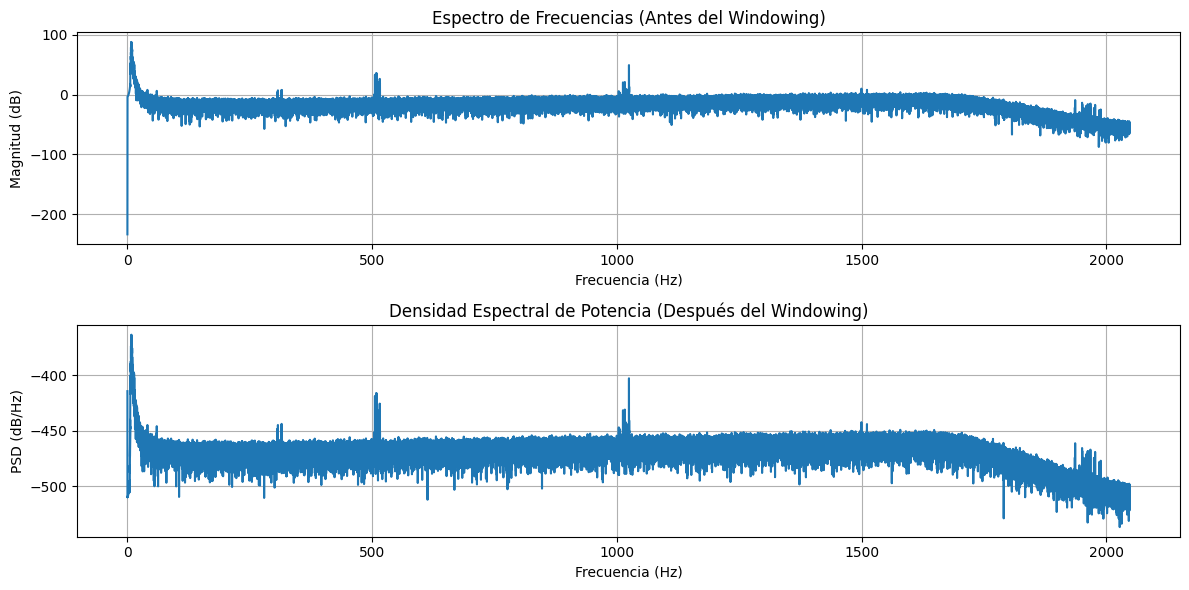

In [7]:
# Calcular la FFT
fft_valores = fft(whitened_strained_tukey)
frecuencias = fftfreq(strain.size, d=1/4096)

# Seleccionar las frecuencias positivas y sus magnitudes
frecuencias_positivas = frecuencias[:len(frecuencias)//2]
magnitudes_positivas = np.abs(fft_valores)[:len(fft_valores)//2]

# Calcular la densidad espectral de potencia (PSD)
f_psd, psd = welch(strain, fs=4096, nperseg=len(strain))

# Convertir las magnitudes a dB
magnitudes_dB = 20 * np.log10(magnitudes_positivas)
psd_dB = 10 * np.log10(psd)

# Graficar el espectro de frecuencias (solo frecuencias positivas) antes y después del windowing
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frecuencias_positivas, magnitudes_dB)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.title('Espectro de Frecuencias (Antes del Windowing)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(f_psd, psd_dB)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.title('Densidad Espectral de Potencia (Después del Windowing)')
plt.grid(True)

plt.tight_layout()
plt.show()


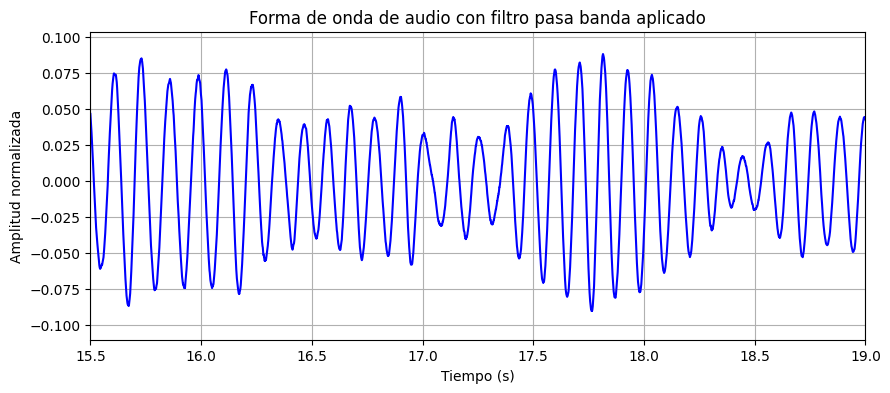

In [8]:
from scipy.signal import butter, filtfilt

# Definir la frecuencia de corte del filtro pasa banda
lowcut = 20  # Frecuencia de corte inferior en Hz
highcut = 250  # Frecuencia de corte superior en Hz
fs = 4096  # Frecuencia de muestreo (debes proporcionar la correcta)

# Orden del filtro (ajústalo según sea necesario)
order = 2

# Calcular las frecuencias de corte normalizadas
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

# Crear el filtro pasa banda
b, a = butter(order, [low, high], btype='band')

# Aplicar el filtro a la señal blanqueada
filtered_strained_tukey = filtfilt(b, a, whitened_strained_tukey)

# Graficar la forma de onda del audio con el filtro pasa banda aplicado
plt.figure(figsize=(10, 4))
plt.plot(time, filtered_strained_tukey, color='b')
plt.title('Forma de onda de audio con filtro pasa banda aplicado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud normalizada')
plt.xlim([15.5,19])
plt.grid(True)
plt.show()



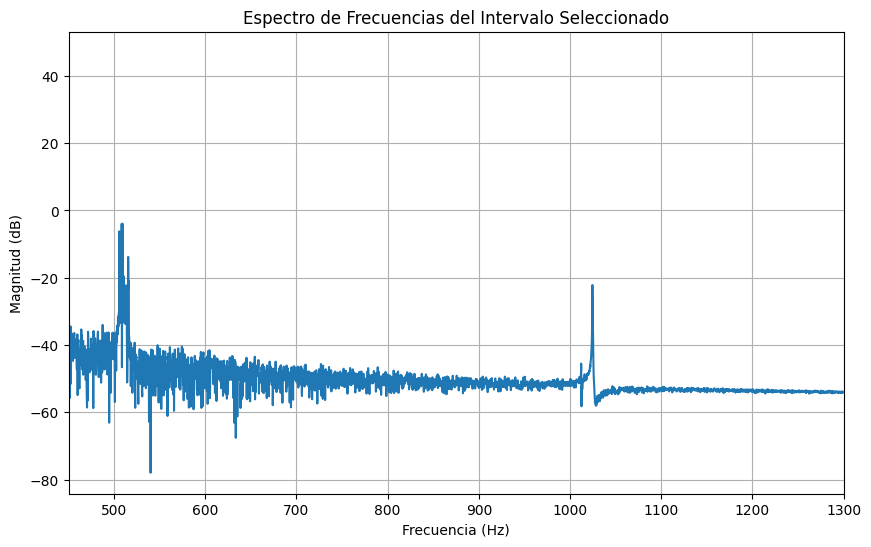

In [9]:
from scipy.fft import fft, fftfreq

# Definir los tiempos de inicio y fin del intervalo de interés
inicio_intervalo = 15.5  # segundos
fin_intervalo = 19.0  # segundos

# Convertir los tiempos a índices de muestra
inicio_muestra = int(inicio_intervalo * fs)
fin_muestra = int(fin_intervalo * fs)

# Seleccionar el intervalo de tiempo de interés
filtered_strained_tukey_intervalo = filtered_strained_tukey[inicio_muestra:fin_muestra]

# Calcular la FFT del intervalo de tiempo seleccionado
fft_valores_intervalo = fft(filtered_strained_tukey_intervalo)
frecuencias_intervalo = fftfreq(filtered_strained_tukey_intervalo.size, d=1/fs)

# Seleccionar las frecuencias positivas y sus magnitudes
frecuencias_positivas_intervalo = frecuencias_intervalo[:len(frecuencias_intervalo)//2]
magnitudes_positivas_intervalo = np.abs(fft_valores_intervalo)[:len(fft_valores_intervalo)//2]

# Convertir las magnitudes a dB
magnitudes_dB_intervalo = 20 * np.log10(magnitudes_positivas_intervalo)

# Graficar el espectro de frecuencias del intervalo seleccionado
plt.figure(figsize=(10, 6))
plt.plot(frecuencias_positivas_intervalo, magnitudes_dB_intervalo)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.title('Espectro de Frecuencias del Intervalo Seleccionado')
plt.grid(True)
plt.xlim([450, 1300])
plt.show()


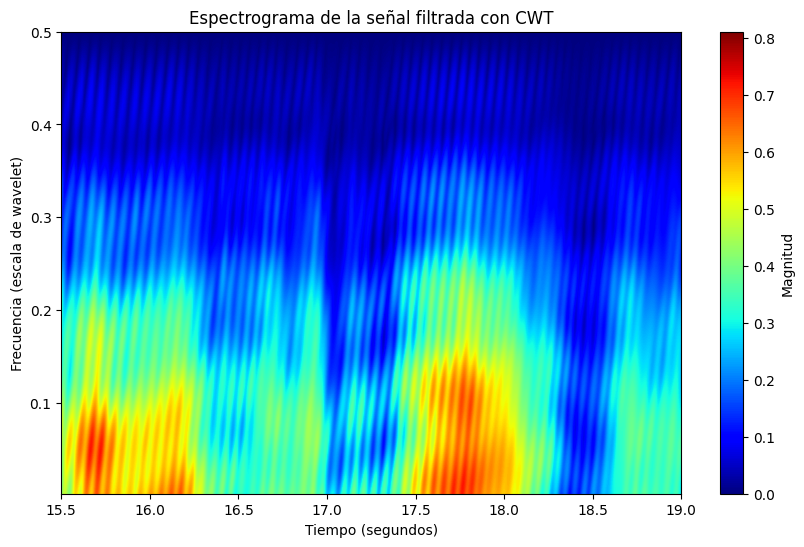

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Parámetros de la transformada de wavelet continua (CWT)
wavelet = 'cmor'  # Tipo de wavelet, puedes cambiarlo según tus necesidades
scales = np.arange(1, 256)  # Escalas para la CWT

# Calcular el tiempo en segundos
tiempo_segundos = time

# Aplicar la CWT a la señal filtrada
coefficients, frequencies = pywt.cwt(filtered_strained_tukey, scales, wavelet)

# Visualizar el resultado como un espectrograma
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), extent=[tiempo_segundos[0], tiempo_segundos[-1], frequencies[-1], frequencies[0]], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitud')
plt.title('Espectrograma de la señal filtrada con CWT')
plt.xlabel('Tiempo (segundos)')
plt.xlim([15.5,19])
plt.ylabel('Frecuencia (escala de wavelet)')
plt.show()


# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

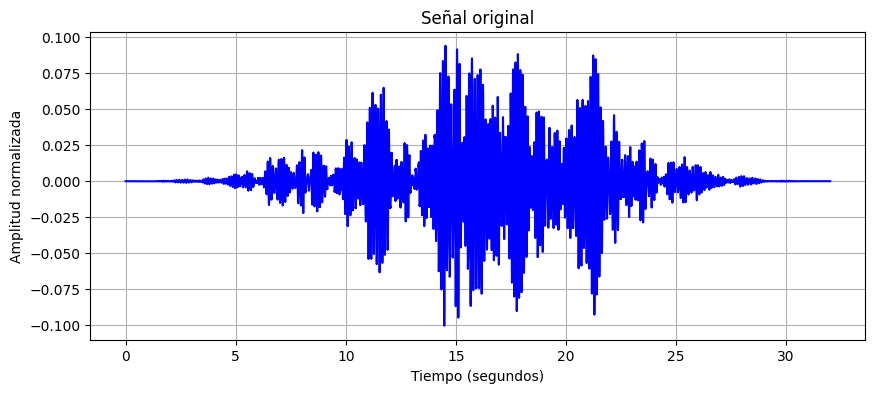

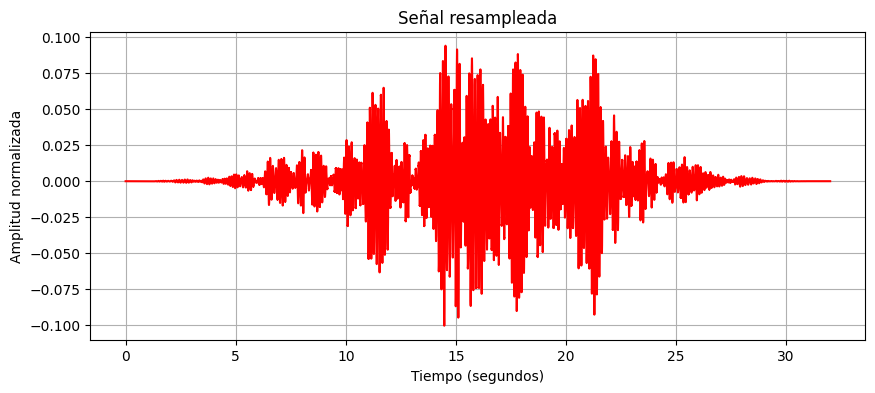

In [22]:
from scipy.signal import resample

# Definir la nueva frecuencia de muestreo deseada
nueva_fs = 2000 # Nueva frecuencia de muestreo en Hz

# Calcular el número de muestras para la nueva señal
nueva_longitud = int(len(filtered_strained_tukey) * (nueva_fs / fs))

# Realizar el resampling
resampled_signal = resample(filtered_strained_tukey, nueva_longitud)

# Calcular el nuevo tiempo en segundos
nuevo_tiempo_segundos = np.arange(nueva_longitud) / nueva_fs

# Visualizar la señal original
plt.figure(figsize=(10, 4))
plt.plot(tiempo_segundos, filtered_strained_tukey, color='b')
plt.title('Señal original')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud normalizada')
plt.grid(True)
plt.show()

# Visualizar la señal resampleada
plt.figure(figsize=(10, 4))
plt.plot(nuevo_tiempo_segundos, resampled_signal, color='r')
plt.title('Señal resampleada')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud normalizada')
plt.grid(True)
plt.show()



In [23]:
# Convierte a audio WAV (normalizando la señal para evitar clipping)
strain_normalizado_re = resampled_signal / np.max(np.abs(resampled_signal))
wavfile.write("strain_re.wav", 1000, strain_normalizado) # Ajusta la frecuencia de muestreo si es diferente

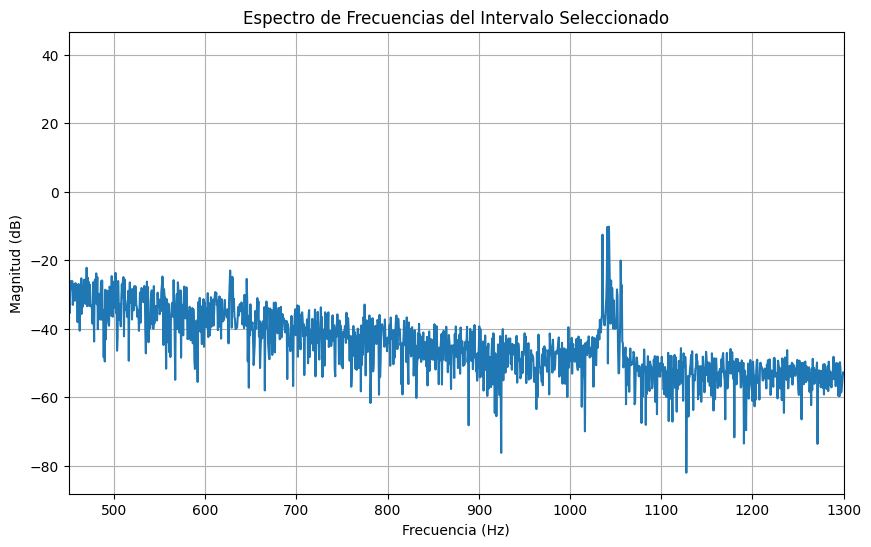

In [24]:
from scipy.fft import fft, fftfreq

# Definir los tiempos de inicio y fin del intervalo de interés
inicio_intervalo = 15.5  # segundos
fin_intervalo = 19.0  # segundos

# Convertir los tiempos a índices de muestra
inicio_muestra = int(inicio_intervalo * nueva_fs)
fin_muestra = int(fin_intervalo * nueva_fs)

# Seleccionar el intervalo de tiempo de interés
filtered_strained_tukey_intervalo = resampled_signal[inicio_muestra:fin_muestra]

# Calcular la FFT del intervalo de tiempo seleccionado
fft_valores_intervalo = fft(filtered_strained_tukey_intervalo)
frecuencias_intervalo = fftfreq(filtered_strained_tukey_intervalo.size, d=1/fs)

# Seleccionar las frecuencias positivas y sus magnitudes
frecuencias_positivas_intervalo = frecuencias_intervalo[:len(frecuencias_intervalo)//2]
magnitudes_positivas_intervalo = np.abs(fft_valores_intervalo)[:len(fft_valores_intervalo)//2]

# Convertir las magnitudes a dB
magnitudes_dB_intervalo = 20 * np.log10(magnitudes_positivas_intervalo)

# Graficar el espectro de frecuencias del intervalo seleccionado
plt.figure(figsize=(10, 6))
plt.plot(frecuencias_positivas_intervalo, magnitudes_dB_intervalo)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.title('Espectro de Frecuencias del Intervalo Seleccionado')
plt.grid(True)
plt.xlim([450, 1300])
plt.show()


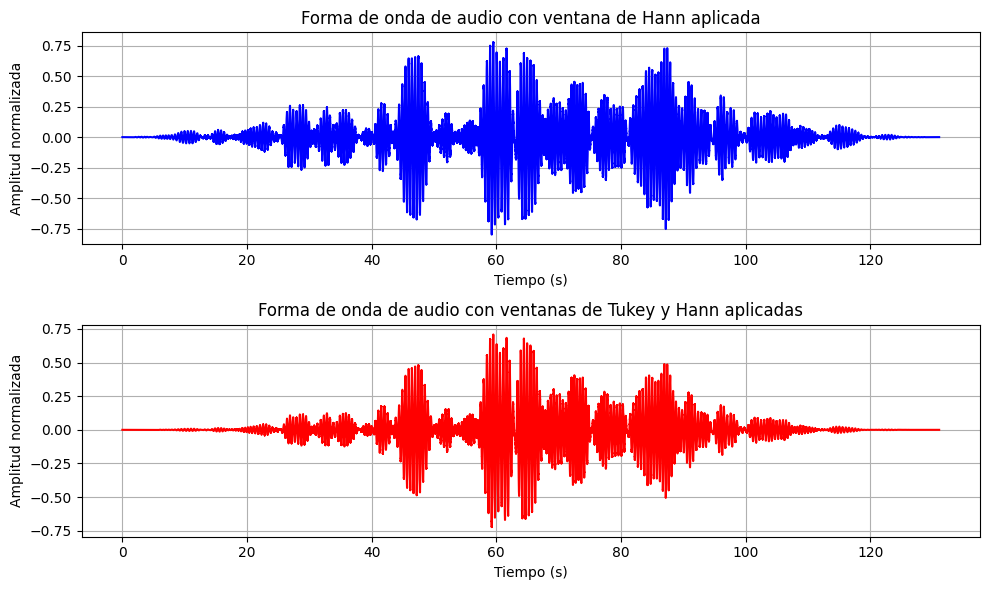

In [31]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# Leer el archivo de audio WAV
fs_re, strain_normalizado_re = wavfile.read("strain_re.wav")

# Calcular la duración del audio en segundos
duration_re = len(strain_normalizado_re) / fs_re

# Crear un arreglo de tiempo
time_re = np.linspace(0., duration, len(strain_normalizado))

# Crear una ventana de Hann del mismo tamaño que el audio
hann_window_re = np.hanning(len(strain_normalizado_re))

# Aplicar la ventana de Hann al audio
strained_hann_re = strain_normalizado_re * hann_window_re

# Crear una ventana de Tukey
alpha = 0.5  # Parámetro de la ventana de Tukey (0: ventana rectangular, 1: ventana de Hann)
tukey_window = np.concatenate([
    np.linspace(0, 1, int(len(strain_normalizado_re) * alpha)),
    np.ones(len(strain_normalizado_re) - int(len(strain_normalizado_re) * alpha) * 2),
    np.linspace(1, 0, int(len(strain_normalizado_re) * alpha))
])

# Aplicar la ventana de Tukey al audio después de la ventana de Hann
strained_tukey_re = strained_hann_re * tukey_window

# Graficar la forma de onda del audio con la ventana de Hann aplicada
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time_re, strained_hann_re, color='b')
plt.title('Forma de onda de audio con ventana de Hann aplicada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud normalizada')
plt.grid(True)

# Graficar la forma de onda del audio con la ventana de Tukey y Hann aplicadas
plt.subplot(2, 1, 2)
plt.plot(time_re, strained_tukey_re, color='r')
plt.title('Forma de onda de audio con ventanas de Tukey y Hann aplicadas')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud normalizada')
plt.grid(True)

plt.tight_layout()
plt.show()

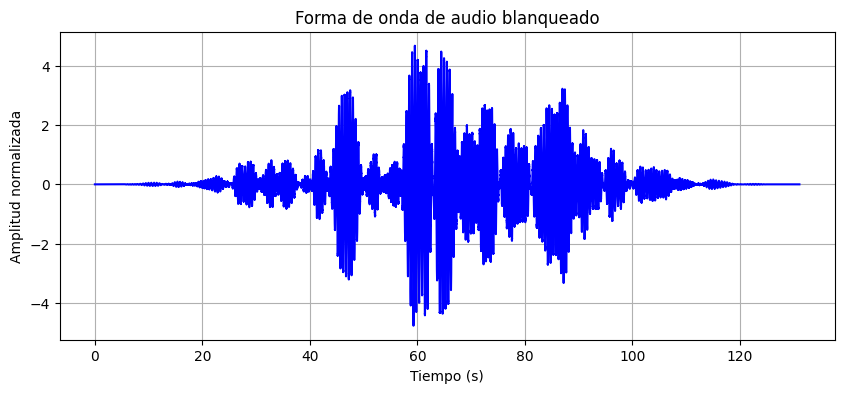

In [34]:
from scipy.signal import lfilter

# Calcular la media de la señal
mean_strained_tukey_re = np.mean(strained_tukey_re)

# Calcular la desviación estándar de la señal
std_strained_tukey_re = np.std(strained_tukey_re)

# Blanquear la señal
whitened_strained_resample = (strained_tukey_re - mean_strained_tukey_re) / std_strained_tukey_re

# Graficar la forma de onda del audio blanqueado
plt.figure(figsize=(10, 4))
plt.plot(time, whitened_strained_resample, color='b')
plt.title('Forma de onda de audio blanqueado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud normalizada')
plt.grid(True)
plt.show()

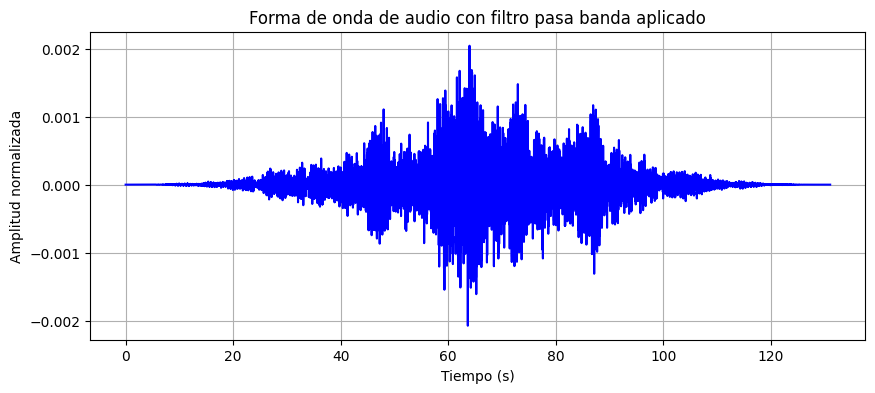

In [49]:
from scipy.signal import butter, filtfilt

# Definir la frecuencia de corte del filtro pasa banda
lowcut = 20  # Frecuencia de corte inferior en Hz
highcut = 50  # Frecuencia de corte superior en Hz
fs = 2000  # Frecuencia de muestreo (debes proporcionar la correcta)

# Orden del filtro (ajústalo según sea necesario)
order = 2

# Calcular las frecuencias de corte normalizadas
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

# Crear el filtro pasa banda
b, a = butter(order, [low, high], btype='band')

# Aplicar el fifiltered_strained_tukeyltro a la señal blanqueada
filtered_strained_tukey = filtfilt(b, a, whitened_strained_resample)

# Graficar la forma de onda del audio con el filtro pasa banda aplicado
plt.figure(figsize=(10, 4))
plt.plot(time_re, filtered_strained_tukey, color='b')
plt.title('Forma de onda de audio con filtro pasa banda aplicado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud normalizada')
#plt.xlim([65.5,70])
plt.grid(True)
plt.show()

In [56]:
# Convertir la señal a un formato compatible con WAV (int16)
audio_data = np.int16(filtered_strained_tukey * 32767)

# Guardar la señal como un archivo WAV
write('audio_filtrado.wav', fs, audio_data)
